In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score 
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [2]:
SEED = 11

Будем учиться классифицировать жанры музыки, пользуясь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [3]:
data = pd.read_csv("../data/train.csv")
df = data.copy()#сохраним исходный датафрейм на всякий
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [4]:
#сколько чего
print(f'Треков {data.shape[0]} и фичей {data.shape[1]}')

Треков 17996 и фичей 17


In [5]:
#типы переменных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

> много числовых фичей => надо разобраться какие категориальные + дропнуть Artist Name и Track Name (строки) (хотя кстати, наверно, имя артиста можно было бы закодировать как категориальную переменную, но сейчас ниже посмотрим сколько там вариантов)

In [6]:
#проверим сколько уникальных значений по столбцам
data.nunique()

Artist Name            9149
Track Name            15129
Popularity              100
danceability            909
energy                 1208
key                      11
loudness               9002
mode                      2
speechiness            1194
acousticness           3930
instrumentalness       4253
liveness               1459
valence                1320
tempo                 13562
duration_in min/ms    14121
time_signature            4
Class                    11
dtype: int64

>да, вариантов среди артистов много => будем выкидывать эти (Artist Name и Track Name) фичи. Popularity, key, mode, time_signature - их можно взять за категориальные

In [7]:
data[['Popularity', 'key', 'mode', 'time_signature']] = data[['Popularity', 'key', 'mode', 'time_signature']].astype("category")
data = data.drop(['Artist Name', 'Track Name'], axis=1)
data.head(3)

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.0171,NaN,0.0849,0.899,134.071,234596.0,4,5
1,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.0011,0.004010,0.1010,0.569,116.454,251733.0,4,10
2,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.4860,0.000196,0.3940,0.787,147.681,109667.0,4,6


In [8]:
#пропущенные значения и пр. 
#Кол-во NA
print(f'Количество NA: {(data.isnull().sum()).sum()}')#много NA. ниже глянем где они конкретно сидят
#Дубликаты
print(f'Количество дубликатов: {(data[data.duplicated()]).shape[0]}')

Количество NA: 6819
Количество дубликатов: 41


>Есть много NA => с ними надо что-то делать (смотрим ниже). И есть ещё строки-дубликаты, но к ним вернёмся после NA. Сейчас повнимательнее посмотрим где NA:

In [9]:
data.isna().sum()

Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64

>так, можно либо дропнуть колонки, где есть NA, либо удалить строки с NA, либо чем-нибудь заполнить NA. Попробуем разное

> **Первый датафрейм** : удаление фичей с пропусками

In [10]:
#Первый датафрейм: удаление фичей с пропусками
data_wo_na_cols = data.drop(['Popularity', 'key', 'instrumentalness'], axis=1)

In [11]:
#небольшая сводочка для "без КОЛОНОК"
print('----Убрали колонки с NA----')
print(f'Треков {data_wo_na_cols.shape[0]} и фичей {data_wo_na_cols.shape[1]}')
#Кол-во NA
print(f'Количество NA: {(data_wo_na_cols.isnull().sum()).sum()}')#много NA. ниже глянем где они конкретно сидят
#Дубликаты
print(f'Количество дубликатов: {(data_wo_na_cols[data_wo_na_cols.duplicated()]).shape[0]}')

----Убрали колонки с NA----
Треков 17996 и фичей 12
Количество NA: 0
Количество дубликатов: 46


> **Второй датафрейм** : удаление строк с пропусками

In [12]:
#Второй датафрейм: удаление строк с пропусками
data_wo_na_rows = data.dropna()

In [13]:
#небольшая сводочка для "без СТРОК"
print('----Убрали строки с NA----')
print(f'Треков {data_wo_na_rows.shape[0]} и фичей {data_wo_na_rows.shape[1]}')
#Кол-во NA
print(f'Количество NA: {(data_wo_na_rows.isnull().sum()).sum()}')#много NA. ниже глянем где они конкретно сидят
#Дубликаты
print(f'Количество дубликатов: {(data_wo_na_rows[data_wo_na_rows.duplicated()]).shape[0]}')

----Убрали строки с NA----
Треков 11813 и фичей 15
Количество NA: 0
Количество дубликатов: 26


> **Третий датафрейм** : заполнение пропусков модой

*В обычных случаях можно было бы заполнить медианой, средним или модой (вариантов больше конечно), но мне не нравится каждый из вариантов. Здесь категориальный признак, поэтому давайте просто посмотрим к чему нас приведёт то, что мы просто пропуски заполним самым частым значением, хотя конечно это вносит дисбаланс в фиче*

In [14]:
#Третий датафрейм: заполнение самым частым значением 
data_fill_na = data.copy()
data_fill_na['Popularity'] = data_fill_na['Popularity'].fillna(data_fill_na['Popularity'].mode()[0])
data_fill_na['key'] = data_fill_na['key'].fillna(data_fill_na['key'].mode()[0])
data_fill_na['instrumentalness'] = data_fill_na['instrumentalness'].fillna(data_fill_na['instrumentalness'].mode()[0])

In [15]:
#небольшая сводочка для "заполненные"
print('----Заполнили NA----')
print(f'Треков {data_fill_na.shape[0]} и фичей {data_fill_na.shape[1]}')
#Кол-во NA
print(f'Количество NA: {(data_fill_na.isnull().sum()).sum()}')#много NA. ниже глянем где они конкретно сидят
#Дубликаты
print(f'Количество дубликатов: {(data_fill_na[data_fill_na.duplicated()]).shape[0]}')

----Заполнили NA----
Треков 17996 и фичей 15
Количество NA: 0
Количество дубликатов: 41


> Возвращаемся к дубликатам:

In [16]:
data[data.duplicated(keep=False)].sort_values(by='Popularity').head(4)
#ну ещё раз, что они есть (пример на исходном датасете) => давайте удалим их из наших новоиспечённых

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
6998,1.0,0.562,0.961,4.0,-7.338,1,0.0617,0.00486,0.7960,0.149,0.960,125.036,450547.0,4,1
8455,1.0,0.562,0.961,4.0,-7.338,1,0.0617,0.00486,0.7960,0.149,0.960,125.036,450547.0,4,1
9263,21.0,0.403,0.579,5.0,-8.123,0,0.0388,0.12800,0.0219,0.096,0.236,100.019,209400.0,4,9
3100,21.0,0.403,0.579,5.0,-8.123,0,0.0388,0.12800,0.0219,0.096,0.236,100.019,209400.0,4,9


In [17]:
#Первый датафрейм
data_wo_na_cols = data_wo_na_cols.drop_duplicates()
print(f'Осталось дубликатов: {(data_wo_na_cols[data_wo_na_cols.duplicated()]).shape[0]}')

Осталось дубликатов: 0


In [18]:
#Второй датафрейм
data_wo_na_rows = data_wo_na_rows.drop_duplicates()
print(f'Осталось дубликатов: {(data_wo_na_rows[data_wo_na_rows.duplicated()]).shape[0]}')

Осталось дубликатов: 0


In [19]:
#Второй датафрейм
data_fill_na = data_fill_na.drop_duplicates()
print(f'Осталось дубликатов: {(data_fill_na[data_fill_na.duplicated()]).shape[0]}')

Осталось дубликатов: 0


> Теперь баланс классов

In [20]:
#баланс классов:
data_wo_na_cols['Class'].value_counts()

Class
10    4927
6     2584
9     2521
8     1849
5     1445
1     1369
2     1267
0      624
7      575
3      402
4      387
Name: count, dtype: int64

In [21]:
#баланс классов:
data_wo_na_rows['Class'].value_counts()

Class
10    3363
6     2037
8     1518
9     1098
1     1033
2      954
5      516
7      464
0      386
3      270
4      148
Name: count, dtype: int64

In [22]:
#баланс классов:
data_fill_na['Class'].value_counts()

Class
10    4929
6     2584
9     2521
8     1849
5     1445
1     1369
2     1268
0      625
7      576
3      402
4      387
Name: count, dtype: int64

> дисбаланс конечно есть (самый большой класс в 12 (а то и в >20) раз больше самого маленького)

----------energy----------


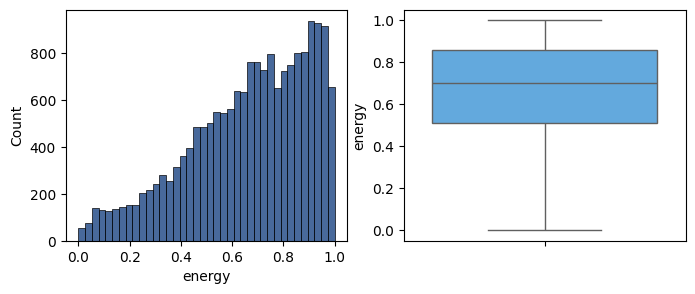

----------key----------


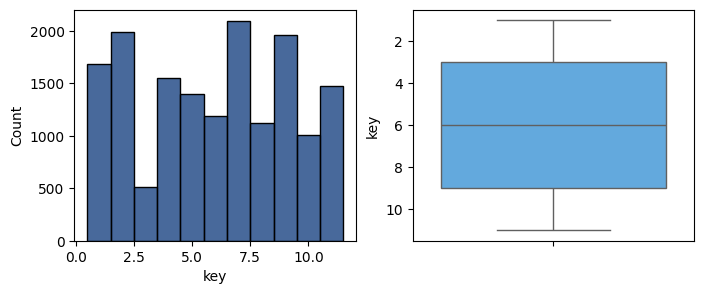

----------loudness----------


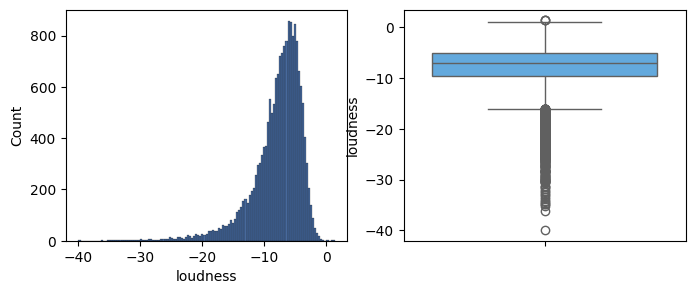

----------mode----------


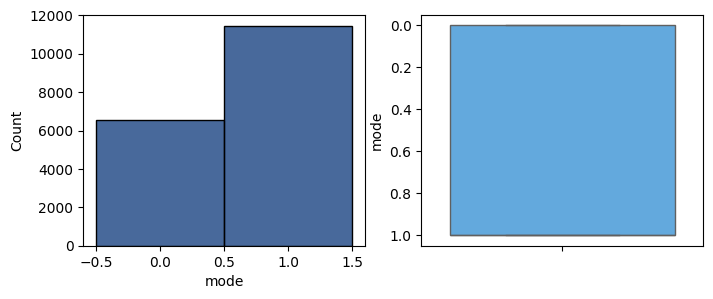

----------speechiness----------


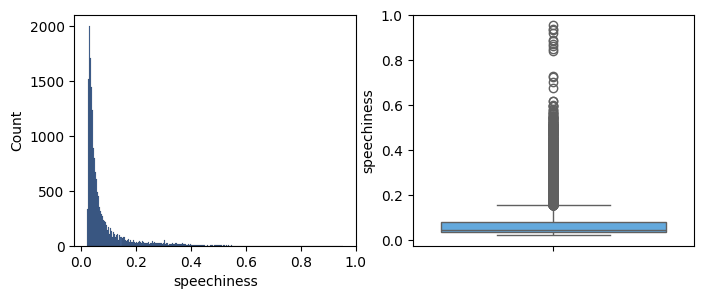

----------acousticness----------


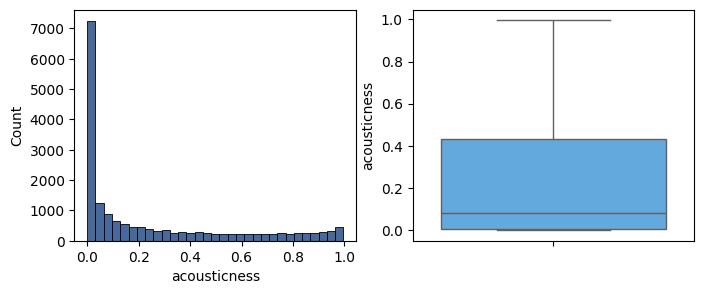

----------instrumentalness----------


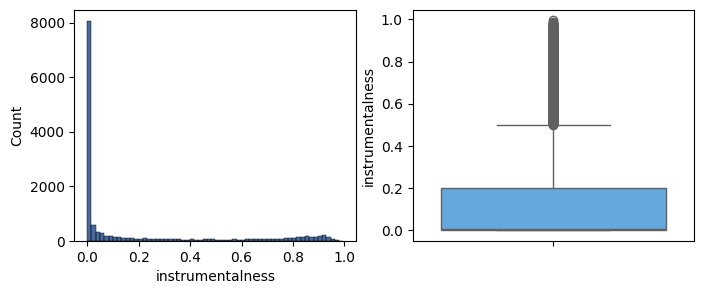

----------liveness----------


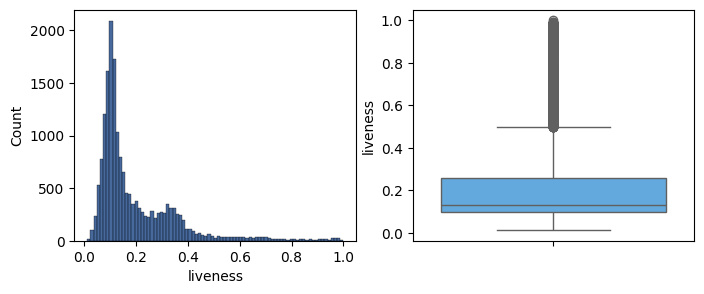

----------valence----------


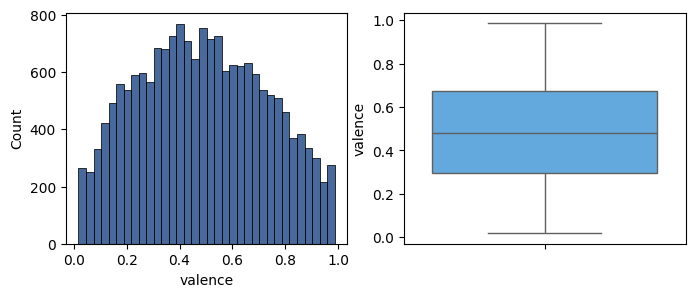

----------tempo----------


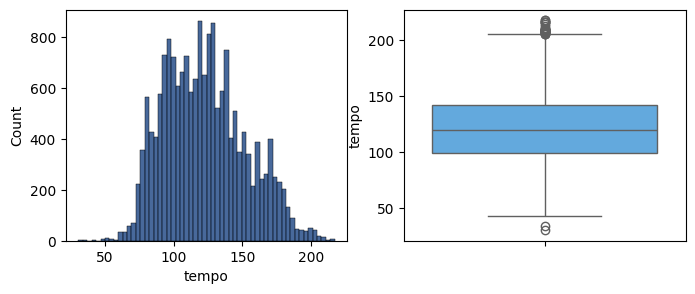

----------duration_in min/ms----------


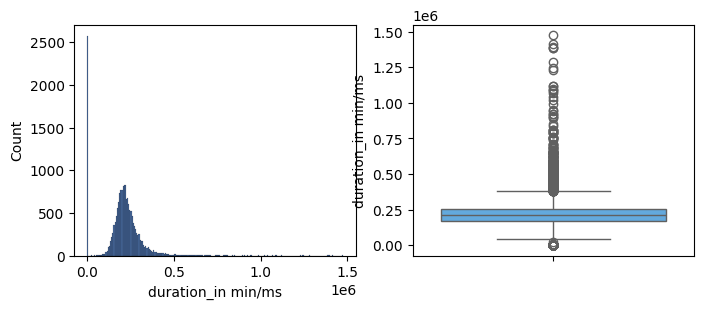

----------time_signature----------


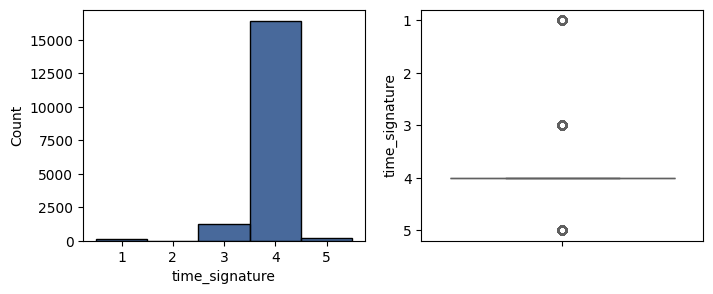

----------Class----------


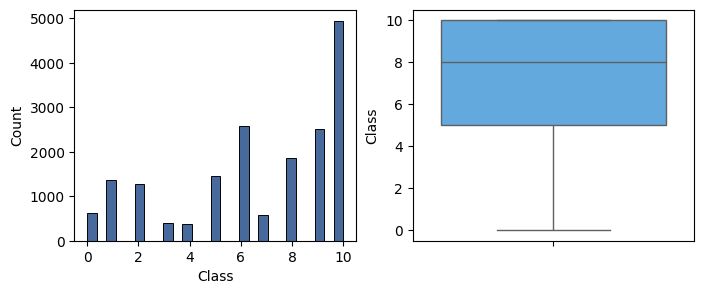

In [23]:
# и всё такое: давайте глянем боксплоты и гистограммки
for i in range(2,len(data.columns)):
    print(f'----------{data.columns[i]}----------')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    sns.histplot(data
                 .iloc[:, i], ax=ax1, color='#0a377a')
    sns.boxplot(data.iloc[:, i], ax=ax2, color='#4facf1')
    plt.show()

> На боксплотах конечно видны точки за пределами 1.5*IQR, но там сконцентрировано много точек, поэтому не будем считать это выбросами.

In [10]:
#FUN-POINT
#делаем рандом на песню и слушаем: я для дальнейшей работы над дз, Вы для дальнейшей проверки (сори, если выпадет что-то, что не по вкусу)
data.sample() #у меня был: Mark Turner - Skylark (мне не зашло). А у Вас?

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
2447,Mark Turner,Skylark,40.0,0.477,0.0775,NaN,-19.338,0,0.0481,0.927,0.253,0.112,0.205,115.488,5.926667,4,7


### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

> **Первый датафрейм (без колонок с NA)**

In [24]:
#Сплитим
X = data_wo_na_cols.drop(['Class'], axis=1)
Y = data_wo_na_cols['Class']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = SEED)

In [25]:
#подбор модели
dt_model = GridSearchCV(DecisionTreeClassifier(), 
                          {'max_depth': [1, 3, 5, 7, 10],
                           'min_samples_leaf': [1, 3, 5, 10], 
                           'min_samples_split': [2, 3, 5, 10],
                           'criterion': ['gini', 'entropy'],
                           'random_state': [SEED]
                          }
                        ).fit(X_train, y_train)

In [26]:
#лучшая
dt_model.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'random_state': 11}

In [27]:
#предсказания
y_pred_proba = dt_model.predict_proba(X_test)
y_pred = dt_model.predict(X_test)

In [28]:
#метрики
print(f'Accuracy = {accuracy_score(y_true=y_test, y_pred=y_pred):1.2f}')
print(f'Balanced accuracy = {balanced_accuracy_score(y_true=y_test, y_pred=y_pred):1.2f}') #нашла такое, решила поглядеть ( унас же дисбаланс классов)
print(f'ROC AUC (ovr) = {roc_auc_score(y_true=y_test, y_score=y_pred_proba, average='macro', multi_class='ovr'):1.2f}') #ЧУВСТВИТЕЛЕН К ДИСБАЛАНСУ
print(f'ROC AUC (ovo) = {roc_auc_score(y_true=y_test, y_score=y_pred_proba, average='macro', multi_class='ovo'):1.2f}') #НЕ ЧУВСТВИТЕЛЕН К ДИСБАЛАНСУ

Accuracy = 0.45
Balanced accuracy = 0.43
ROC AUC (ovr) = 0.85
ROC AUC (ovo) = 0.88


> Было интересно сравнить насколько будут различаться пары (accuracy, balanced_accuracy) и (roc_auc ovr, roc_auc ovo) на наших данных с дисбалансом классов. Интересно, что значения обоих пар между собой близки друг к другу
> А если в целом, то accuracy, при условии, что у нас 11 классов, имеет неплохое значение (бейзлайн 1/11~0,09). ROC AUC тоже неплоха.
>
> *дальше будем тоде наблюдать за метриками чувствительными/нет к дисбалансу*

> **Второй датафрейм (без строк с NA)**

In [29]:
#Сплитим
X = data_wo_na_rows.drop(['Class'], axis=1)
Y = data_wo_na_rows['Class']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = SEED)

In [30]:
#подбор модели
dt_model = GridSearchCV(DecisionTreeClassifier(), 
                          {'max_depth': [1, 3, 5, 7, 10],
                           'min_samples_leaf': [1, 3, 5, 10], 
                           'min_samples_split': [2, 3, 5, 10],
                           'criterion': ['gini', 'entropy'],
                           'random_state': [SEED]
                          }
                        ).fit(X_train, y_train)

In [31]:
#лучшая
dt_model.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'random_state': 11}

In [32]:
#предсказания
y_pred_proba = dt_model.predict_proba(X_test)
y_pred = dt_model.predict(X_test)

In [33]:
#метрики
print(f'Accuracy = {accuracy_score(y_true=y_test, y_pred=y_pred):1.2f}')
print(f'Balanced accuracy = {balanced_accuracy_score(y_true=y_test, y_pred=y_pred):1.2f}') #нашла такое, решила поглядеть
print(f'ROC AUC (ovr) = {roc_auc_score(y_true=y_test, y_score=y_pred_proba, average='macro', multi_class='ovr'):1.2f}') #ЧУВСТВИТЕЛЕН К ДИСБАЛАНСУ
print(f'ROC AUC (ovo) = {roc_auc_score(y_true=y_test, y_score=y_pred_proba, average='macro', multi_class='ovo'):1.2f}') #НЕ ЧУВСТВИТЕЛЕН К ДИСБАЛАНСУ

Accuracy = 0.46
Balanced accuracy = 0.48
ROC AUC (ovr) = 0.85
ROC AUC (ovo) = 0.88


> Значения метрик не сильно изменились относительно предыдущего запуска. Т.е. конкретно в этих случаях не сильно важно оказалось, от чего именно мы откажемся. Но в общем случае всё зависит от задачи. Не стоит выкидывать фичи, если придётся отказаться от многих, и то же самое про строки. Можно ещё заполнять значения (медиана, мода, линейной регрессией и др., но здесь мне показалось это не очень подходящим).
>
>  Что касается лучшей модели (после подбора в GridSearchCV), то все гиперпараметры те же за исключением criterion, который ранее был gini, а теперь entropy.

> **Третий датафрейм (заполненные NA)**

In [34]:
#Сплитим
X = data_fill_na.drop(['Class'], axis=1)
Y = data_fill_na['Class']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = SEED)

In [35]:
#подбор модели
dt_model = GridSearchCV(DecisionTreeClassifier(), 
                          {'max_depth': [1, 3, 5, 7, 10],
                           'min_samples_leaf': [1, 3, 5, 10], 
                           'min_samples_split': [2, 3, 5, 10],
                           'criterion': ['gini', 'entropy'],
                           'random_state': [SEED]
                          }
                        ).fit(X_train, y_train)

In [36]:
#лучшая
dt_model.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'random_state': 11}

In [37]:
#предсказания
y_pred_proba = dt_model.predict_proba(X_test)
y_pred = dt_model.predict(X_test)

In [38]:
#метрики
print(f'Accuracy = {accuracy_score(y_true=y_test, y_pred=y_pred):1.2f}')
print(f'Balanced accuracy = {balanced_accuracy_score(y_true=y_test, y_pred=y_pred):1.2f}') #нашла такое, решила поглядеть ( унас же дисбаланс классов)
print(f'ROC AUC (ovr) = {roc_auc_score(y_true=y_test, y_score=y_pred_proba, average='macro', multi_class='ovr'):1.2f}') #ЧУВСТВИТЕЛЕН К ДИСБАЛАНСУ
print(f'ROC AUC (ovo) = {roc_auc_score(y_true=y_test, y_score=y_pred_proba, average='macro', multi_class='ovo'):1.2f}') #НЕ ЧУВСТВИТЕЛЕН К ДИСБАЛАНСУ

Accuracy = 0.48
Balanced accuracy = 0.52
ROC AUC (ovr) = 0.84
ROC AUC (ovo) = 0.87


> Было интересно сравнить насколько будут различаться пары (accuracy, balanced_accuracy) и (roc_auc ovr, roc_auc ovo) на наших данных с дисбалансом классов. Интересно, что значения обоих пар между собой близки друг к другу
> А если в целом, то accuracy, при условии, что у нас 11 классов, имеет неплохое значение (бейзлайн 1/11~0,09). ROC AUC тоже неплоха.

> На консультации мы обсудили ещё **обучение с весами**. Давайте тут же его затестим (на **втором датафрейме**):

In [39]:
#Сплитим
X = data_wo_na_rows.drop(['Class'], axis=1)
Y = data_wo_na_rows['Class']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = SEED)

In [40]:
#подбор модели
dt_model = GridSearchCV(DecisionTreeClassifier(), 
                          {'max_depth': [1, 3, 5, 7, 10],
                           'min_samples_leaf': [1, 3, 5, 10], 
                           'min_samples_split': [2, 3, 5, 10],
                           'criterion': ['gini', 'entropy'],
                           'class_weight': ['balanced'],
                           'random_state': [SEED]
                          }
                        ).fit(X_train, y_train)

In [41]:
#лучшая
dt_model.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'random_state': 11}

In [42]:
#предсказания
y_pred_proba = dt_model.predict_proba(X_test)
y_pred = dt_model.predict(X_test)

In [43]:
#метрики
print(f'Accuracy = {accuracy_score(y_true=y_test, y_pred=y_pred):1.2f}')
print(f'Balanced accuracy = {balanced_accuracy_score(y_true=y_test, y_pred=y_pred):1.2f}') #нашла такое, решила поглядеть
print(f'ROC AUC (ovr) = {roc_auc_score(y_true=y_test, y_score=y_pred_proba, average='macro', multi_class='ovr'):1.2f}') #ЧУВСТВИТЕЛЕН К ДИСБАЛАНСУ
print(f'ROC AUC (ovo) = {roc_auc_score(y_true=y_test, y_score=y_pred_proba, average='macro', multi_class='ovo'):1.2f}') #НЕ ЧУВСТВИТЕЛЕН К ДИСБАЛАНСУ

Accuracy = 0.38
Balanced accuracy = 0.53
ROC AUC (ovr) = 0.85
ROC AUC (ovo) = 0.89


> Метрики изменились. Причём теперь обычная accuracy стала хуже, а сбалансированная лучше (я рада). Но ROC AUC не особенно изменилась. Но в целом введение не одинаковых весов в модель поменяли ситуацию. Лучшая модель тоже чутка изменилась: теперь min_samples_split равен 5, а не 2 как в двух предыдущих.
>
> Если подводить итог, то здесь, даже при условии, что метрики чутка изменились, всё равно нет особенной разницы в подходах.

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

In [45]:
#Давайте глянем knn: БЕЗ СКЕЙЛА

#Сплитим
X = data_wo_na_rows.drop(['Class'], axis=1)
Y = data_wo_na_rows['Class']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 11)

#нам придётся поскейлить для этой модели, поэтому конечно не получится сравнить модели прям на одних и тех же данных

#подбор модели
knn_model = GridSearchCV(KNeighborsClassifier(),
                         {'n_neighbors': [3, 5, 7, 9, 11, 15],
                          'weights': ["uniform", "distance"],
                          'p': [1, 2]}).fit(X_train, y_train)

#лучшая
print(f'Best knn: {knn_model.best_params_}')

#предсказания
y_pred = knn_model.predict(X_test)

#метрики
print(f'Accuracy = {accuracy_score(y_true=y_test, y_pred=y_pred):1.2f}')
print(f'Balanced accuracy = {balanced_accuracy_score(y_true=y_test, y_pred=y_pred):1.2f}') 

Best knn: {'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}
Accuracy = 0.28
Balanced accuracy = 0.29


In [46]:
#Давайте глянем knn:

#Сплитим
X = data_wo_na_rows.drop(['Class'], axis=1)
Y = data_wo_na_rows['Class']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = SEED)

#нам придётся поскейлить для этой модели, поэтому конечно не получится сравнить модели прям на одних и тех же данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#подбор модели
knn_model = GridSearchCV(KNeighborsClassifier(),
                         {'n_neighbors': [3, 5, 7, 9, 11, 15],
                          'weights': ["uniform", "distance"],
                          'p': [1, 2]}).fit(X_train, y_train)

#лучшая
print(f'Best knn: {knn_model.best_params_}')#тестила без скейла было: {'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}

#предсказания
y_pred = knn_model.predict(X_test)

#метрики
print(f'Accuracy = {accuracy_score(y_true=y_test, y_pred=y_pred):1.2f}')#тестила без скейла было: 0.28
print(f'Balanced accuracy = {balanced_accuracy_score(y_true=y_test, y_pred=y_pred):1.2f}')#тестила без скейла было: 0.29

Best knn: {'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}
Accuracy = 0.47
Balanced accuracy = 0.50


> По метрикам knn здесь оказался близок к дереву решений. (но если не скейлить даннные, то там было намного хуже)

In [47]:
#и логистическую регрессию:

#подбор модели
logr_model = GridSearchCV(LogisticRegression(solver="liblinear", max_iter=100000),
                          {'penalty': ("l1", "l2"),
                           'C': [0.01, 0.1, 1, 10, 100],
                           'random_state': [SEED]}
                          ).fit(X_train, y_train)

#лучшая
print(f'Best knn: {logr_model.best_params_}')

#предсказания
y_pred_proba = logr_model.predict_proba(X_test)
y_pred = logr_model.predict(X_test)

#метрики
print(f'Accuracy = {accuracy_score(y_true=y_test, y_pred=y_pred):1.2f}')
print(f'Balanced accuracy = {balanced_accuracy_score(y_true=y_test, y_pred=y_pred):1.2f}') 
print(f'ROC AUC (ovr) = {roc_auc_score(y_true=y_test, y_score=y_pred_proba, average='macro', multi_class='ovr'):1.2f}') #ЧУВСТВИТЕЛЕН К ДИСБАЛАНСУ
print(f'ROC AUC (ovo) = {roc_auc_score(y_true=y_test, y_score=y_pred_proba, average='macro', multi_class='ovo'):1.2f}') #НЕ ЧУВСТВИТЕЛЕН К ДИСБАЛАНСУ

Best knn: {'C': 10, 'penalty': 'l1', 'random_state': 11}
Accuracy = 0.48
Balanced accuracy = 0.49
ROC AUC (ovr) = 0.87
ROC AUC (ovo) = 0.89


> По метрикам тоже близко к дереву решений, даже на совсем чуть-чуть лучше (~0.01)


>**Итого:**
>
>**метрики**: разница в значениях между чувствительными/нет к дисбалансу метрик была, но не очень большая (~0.01)
>
>**датафрейм**: лучший вариант предобработки данных согласно метрикам оказался третий, т.е. когда мы заполнили NA модами. Однако модель с учётом весов улучшила ситуацию для варианта с отказом от строк с NA (даже лучше просто третьего вариант).
>
>**модели**: среди всех рассмотренных моделей сложно выделить явного лидера. У всех accuracy была порядка 0.40+ и ROC AUC 0.80+.


### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1. 

2. 
  
3. 